<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 : West Nile Virus Prediction
### Notebook 4 of 4: Spray Analysis

## Contents:
- [Import libraries](#Import-libraries)
- [Import data from Pickle](#Import-data-from-Pickle)
- [Define functions](#Define-functions)
- [Spray Analysis](#Spray-Analysis)
- [Findings from Spray Data](#Findings-from-Spray-Data)
- [Conclusion](#Conclusion)

# Import libraries
*Back to [Contents](#Contents:)*

In [1]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd

import datetime

In [2]:
#steps to install geopandas

#!pip install pipwin
#!pipwin install gdal
#!pipwin install fiona
#!pip install geopandas
#!pipwin install rasterio
#!pip install contextily

In [3]:
#!pip install imblearn

In [4]:
#!pip install lightgbm

# Import data from Pickle
*Back to [Contents](#Contents:)*

In [5]:
# read pickle_dict, which stores everything
pickle_dict1 = pickle.load(open('./assets/data1.pkl', 'rb'))

df_train = pickle_dict1['df_train']
df_test = pickle_dict1['df_test']
df_spray = pickle_dict1['df_spray']
df_weather_1 = pickle_dict1['df_weather_1']
df_weather_2 = pickle_dict1['df_weather_2']

## Define functions
*Back to [Contents](#Contents:)*

In [6]:
# the function will 
# 1. plot neighborhoods map of chicago
# 2. plot 2 weather stations on the map
# 3. based on the input parameters,
#   a. convert the input dataframe into geopandas dataframe
#   b. plot the dataframe on the chicago map. 
#   c. if the dataframe contain column 'NumMosquitos', the function will adjust the markersize according to 'NumMosquitos'

def plot_geodata(dict_df,   # dictionary containing dataframe and its name
                ):
    
    colors = ['cyan','orange','black','yellow']
    markersizes = [5, 5, 1, 5]
    # change the zorder to show which one is displayed on top
    zorders = [4, 2, 3, 1]
    
    fig_, ax_ = plt.subplots(figsize=(20,20))
    
    # plot neighborhoods map of chicago
    geojson_file = './assets/Boundaries_Community_Areas.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    # plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude', 'Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry=gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='yellow', markersize=20, zorder=5, label="Weather station")
    
    # plot input dataframes
    i=0
    for label_df, df in dict_df.items():
        color_ = colors[i]
        
        # if the dataframe has column 'NumMosquitos', the markersize will be adjusted according to this column
        if 'NumMosquitos' in df.columns:
            markersize_ = df['NumMosquitos']*3
        else:
            markersize_ = markersizes[i]
        zorder_ = zorders[i]
        label_ = label_df

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_, zorder=zorder_, label=label_)
        
        i += 1
        
    ax_.legend(loc='lower left', fontsize=12, markerscale=3)
    plt.show()
    return 

### Set up a limit table to be used in below function to zoom in to the plot areas

In [7]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13615 entries, 95 to 14834
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       13615 non-null  datetime64[ns]
 1   Time       13615 non-null  object        
 2   Latitude   13615 non-null  float64       
 3   Longitude  13615 non-null  float64       
 4   geometry   13615 non-null  geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), object(1)
memory usage: 638.2+ KB


In [8]:
df_spray.head(20)

,Date,Time,Latitude,Longitude,geometry
95,2011-09-07,7:52:52 PM,41.98,-87.79,POINT (-87.78778 41.98143)
96,2011-09-07,7:53:02 PM,41.98,-87.79,POINT (-87.78778 41.98100)
97,2011-09-07,7:53:12 PM,41.98,-87.79,POINT (-87.78776 41.98056)
98,2011-09-07,7:53:22 PM,41.98,-87.79,POINT (-87.78776 41.98020)
99,2011-09-07,7:53:32 PM,41.98,-87.79,POINT (-87.78776 41.97975)
100,2011-09-07,7:53:42 PM,41.98,-87.79,POINT (-87.78775 41.97935)
101,2011-09-07,7:53:52 PM,41.98,-87.79,POINT (-87.78776 41.97885)
102,2011-09-07,7:54:02 PM,41.98,-87.79,POINT (-87.78777 41.97840)
103,2011-09-07,7:54:12 PM,41.98,-87.79,POINT (-87.78776 41.97799)
104,2011-09-07,7:54:22 PM,41.98,-87.79,POINT (-87.78778 41.97749)


In [9]:
# add an extra 0.018 to limits to see surrounding areas
# drop the Time column so we can apply -0.018 and +0.018

limit_table = pd.merge(df_spray.groupby('Date').min().drop(columns='Time') - 0.018,
                       df_spray.groupby('Date').max().drop(columns='Time') + 0.018, on='Date')
limit_table = limit_table.reset_index()
limit_table

,Date,Latitude_x,Longitude_x,Latitude_y,Longitude_y
0,2011-09-07,41.95,-87.85,42.01,-87.77
1,2013-07-17,41.70,-87.89,42.03,-87.61
2,2013-07-25,41.92,-87.76,41.99,-87.69
3,2013-08-08,41.90,-87.73,41.96,-87.66
4,2013-08-15,41.87,-87.84,41.98,-87.73
5,2013-08-16,41.89,-87.80,41.98,-87.73
6,2013-08-22,41.70,-87.75,41.91,-87.57
7,2013-08-29,41.74,-87.76,42.02,-87.64
8,2013-09-05,41.96,-87.86,42.04,-87.77


In [10]:
# the function is similar to the above plot_geodata EXCEPT
# it zooms in to the area of the spray!

# 1. plot neighborhoods map of chicago
# 2. plot 2 weather stations on the map
# 3. based on the input parameters,
#   a. convert the input dataframe into geopandas dataframe
#   b. plot the dataframe on the chicago map. 
#   c. if the dataframe contain column 'NumMosquitos', the function will adjust the markersize according to 'NumMosquitos'

def plot_spray(dict_df,   # dictionary containing dataframe and its name
               spray_date # if want to visualize the entire plot
                ):
    
    colors = ['cyan','orange','black','yellow']
    markersizes = [5, 5, 1, 5]
    # change the zorder to show which one is displayed on top
    zorders = [4, 2, 3, 1]
    
    fig_, ax_ = plt.subplots(figsize=(15,15))
    
    # returns the index on the table based on the spraydate
    table_index = limit_table[limit_table['Date']==spray_date].index[0]
    
    # set the limits of the plot to visualise the spray area better
    ax_.set_xlim([limit_table.iloc[table_index, 2], limit_table.iloc[table_index, 4]])
    ax_.set_ylim([limit_table.iloc[table_index, 1], limit_table.iloc[table_index, 3]])
        
    # plot neighborhoods map of chicago
    geojson_file = './assets/Boundaries_Community_Areas.geojson'
    neighborhoods = gpd.read_file(geojson_file)
    neighborhoods.plot(ax=ax_)
    
    # plot station
    # initialize list of lists
    list_station = [['1',  41.995,-87.933], ['2', 41.786,-87.752]]
    df_station = pd.DataFrame(list_station, columns=['Station', 'Latitude', 'Longitude'])
    gdf = gpd.GeoDataFrame(df_station, geometry=gpd.points_from_xy(df_station.Longitude, df_station.Latitude))
    gdf.plot(ax=ax_, color='yellow', markersize=20, zorder=5, label="Weather station")
    
    # plot input dataframes
    i=0
    for label_df, df in dict_df.items():
        color_ = colors[i]
        zorder_ = zorders[i]
        label_ = label_df
        
        # if the dataframe has column 'NumMosquitos', the markersize will be adjusted according to this column
        if 'NumMosquitos' in df.columns:
            markersize_ = df['NumMosquitos']*3
        else:
            markersize_ = markersizes[i]
        

        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
        gdf.plot(ax=ax_, color=color_, markersize=markersize_, zorder=zorder_, label=label_)
        i += 1
        
    ax_.legend(loc='lower left', fontsize=12, markerscale=3)
    plt.show()
    return 

# Spray Analysis

*Back to [Contents](#Contents:)*

In [11]:
df_spray['Date'].unique()

array(['2011-09-07T00:00:00.000000000', '2013-07-17T00:00:00.000000000',
       '2013-07-25T00:00:00.000000000', '2013-08-08T00:00:00.000000000',
       '2013-08-15T00:00:00.000000000', '2013-08-16T00:00:00.000000000',
       '2013-08-22T00:00:00.000000000', '2013-08-29T00:00:00.000000000',
       '2013-09-05T00:00:00.000000000'], dtype='datetime64[ns]')

**There are a total of 9 spray dates, 1 in 2011 and the rest in 2013. We want to visualize if the spray area is different in 2011 and 2013.**

In [12]:
# define a table so that we can plot and analyse WNV hotspots!
# find the location (latitude and longitude) of all the hotspots
df_wnvpresent = df_train.query('WnvPresent==1')[['Date', 'Latitude', 'Longitude']]
df_wnvpresent.head()

,Date,Latitude,Longitude
553,2007-07-18,41.69,-87.53
603,2007-07-25,41.67,-87.60
611,2007-07-25,41.67,-87.60
618,2007-07-25,41.67,-87.60
660,2007-07-25,41.67,-87.60


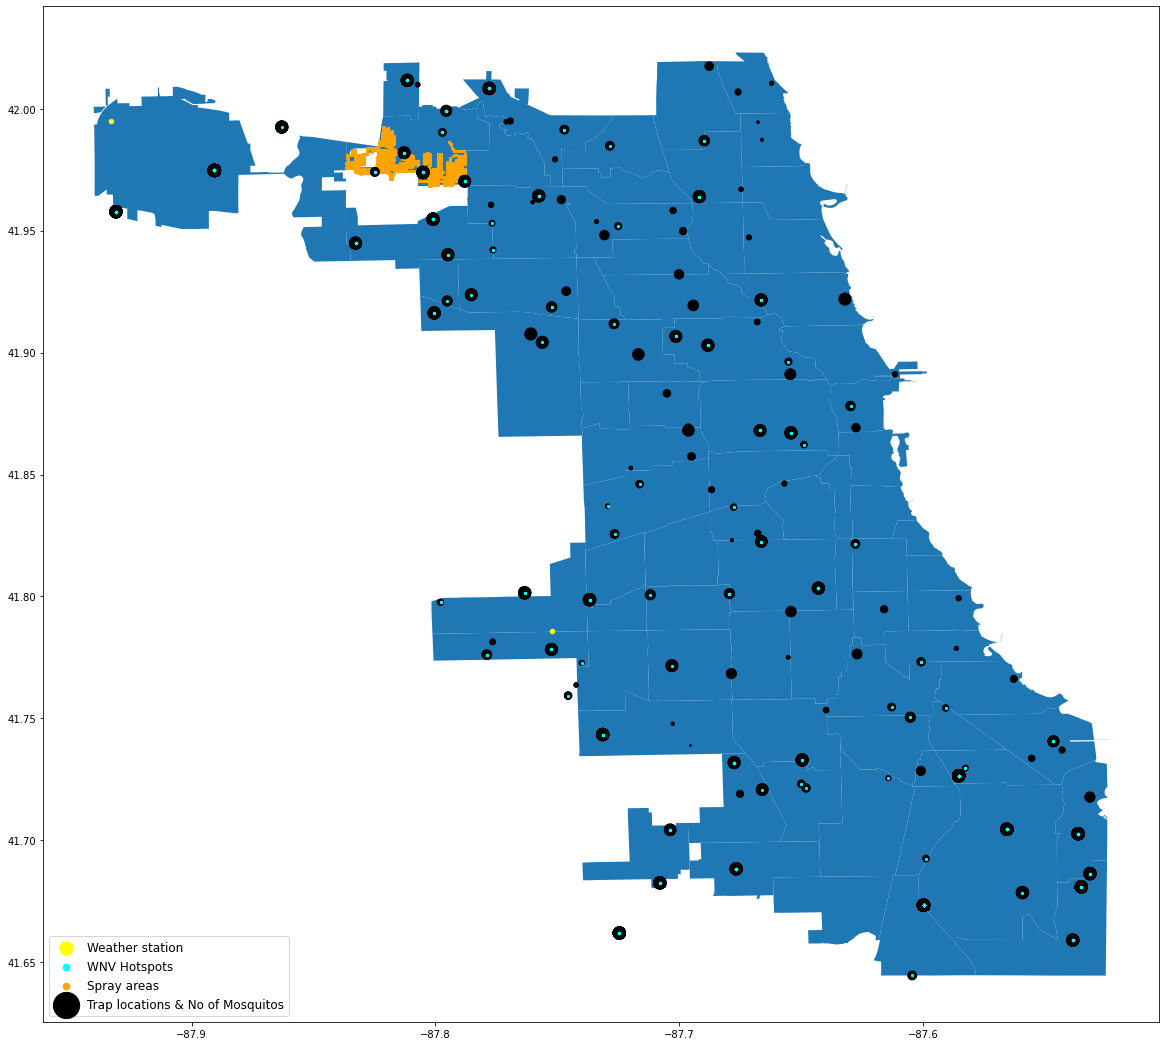

In [13]:
# spray areas in the year 2011
spray_date = pd.Timestamp(2011, 9, 7)

spray_2011 = {'WNV Hotspots':\
              df_wnvpresent[df_wnvpresent["Date"] <= spray_date],
              'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
              'Trap locations & No of Mosquitos':\
              df_train[df_train["Date"] <= spray_date]
                 }
plot_geodata(spray_2011)

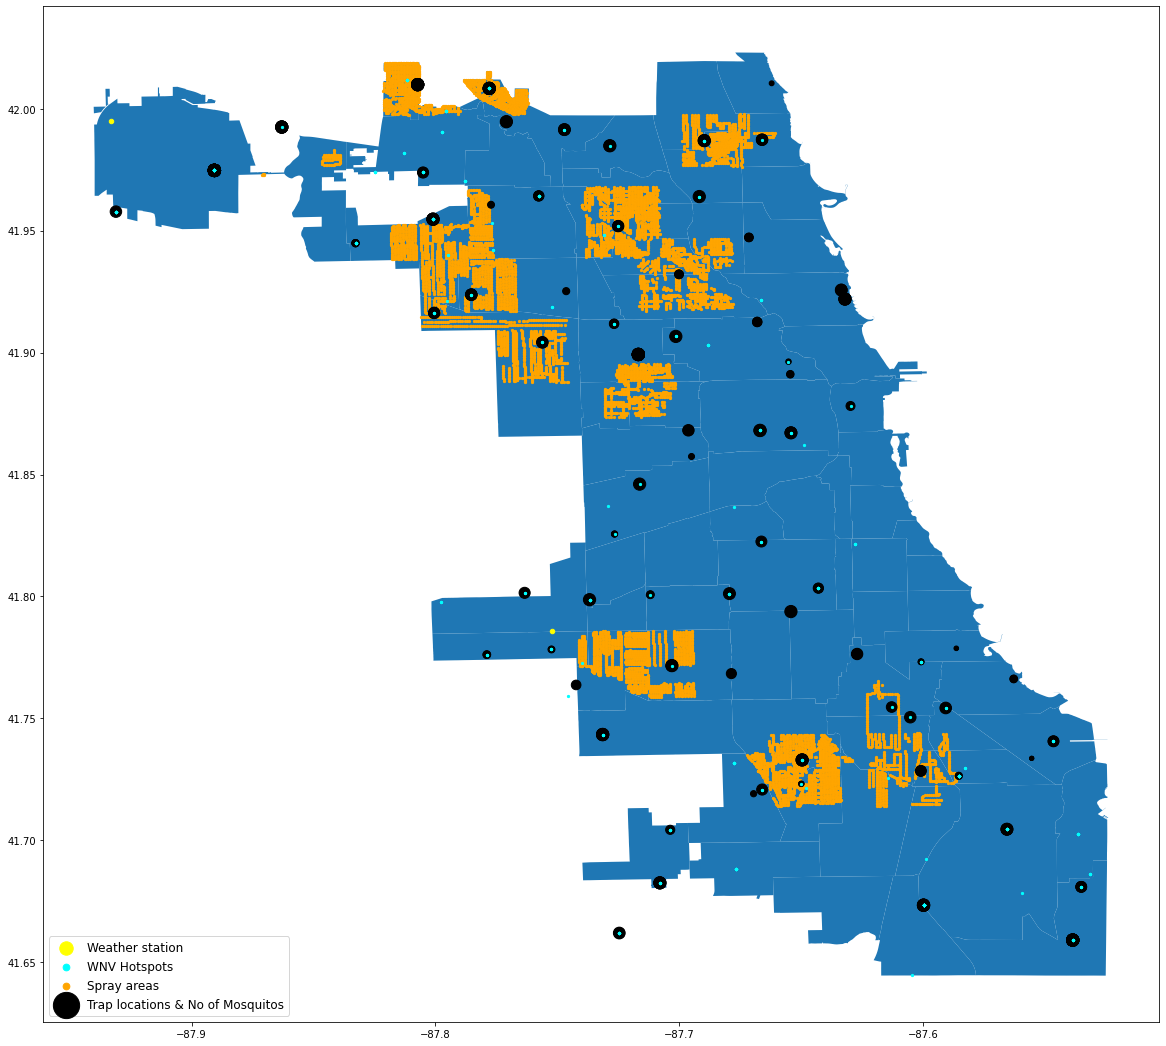

In [14]:
# spray areas in the year 2013
spray_date = pd.Timestamp(2013, 7, 17)

spray_2013 = {'WNV Hotspots':\
              df_wnvpresent[df_wnvpresent["Date"] <= spray_date],
              'Spray areas': df_spray[(df_spray["Date"] >= spray_date)],
              'Trap locations & No of Mosquitos':\
              df_train[df_train["Date"] >= spray_date]
                  }
plot_geodata(spray_2013)

**As we can see from the above 2 graphs, the spray areas are in different areas. To test the effectiveness of the spray, we look at the number of mosquitos two weeks before and two weeks after spraying.**

## Spray effectiveness on 7 Sep 2011

Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE 2011-09-07 00:00:00


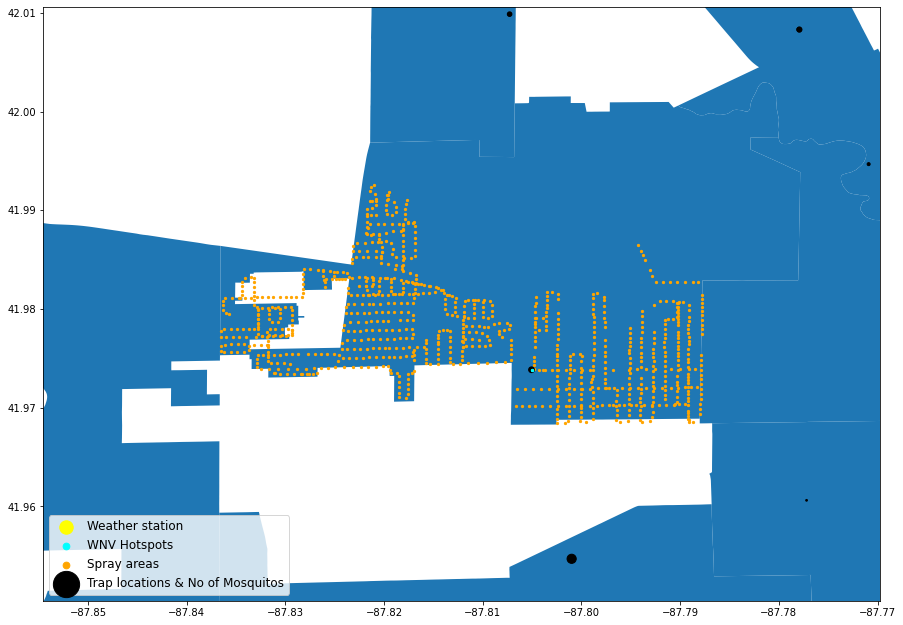

Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER 2011-09-07 00:00:00


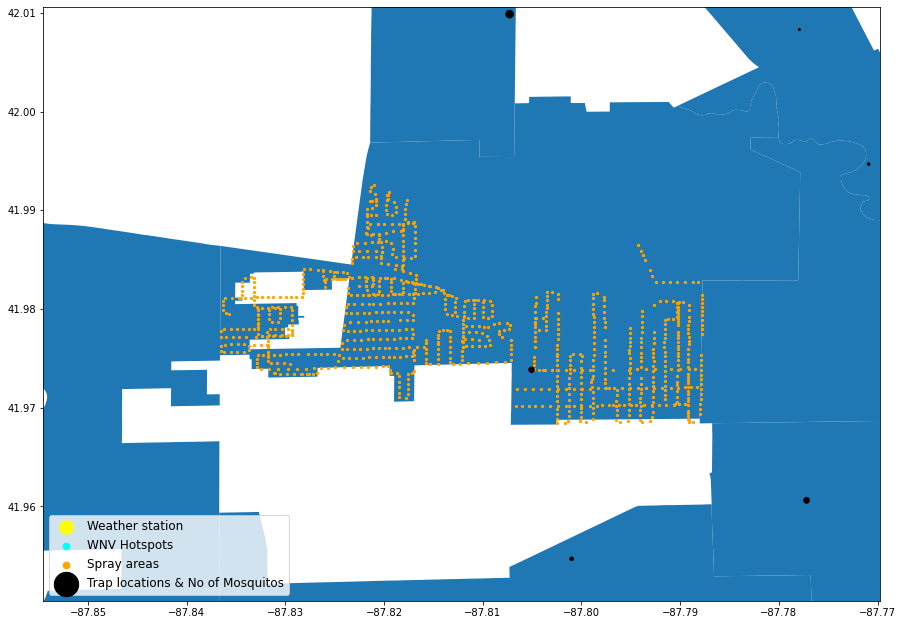

In [15]:
spray_date = pd.Timestamp(2011, 9, 7)

# mosquito numbers and location of hotspots two weeks before spray
two_wks_before = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                                (df_wnvpresent["Date"] < spray_date)],
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                  'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                 }
   
print(f"Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers and location of hotspots two weeks after spray
two_wks_after = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date) &\
                                (df_wnvpresent["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                 'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))] 
                }

print(f"Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 17 July 2013

Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE 2013-07-17 00:00:00


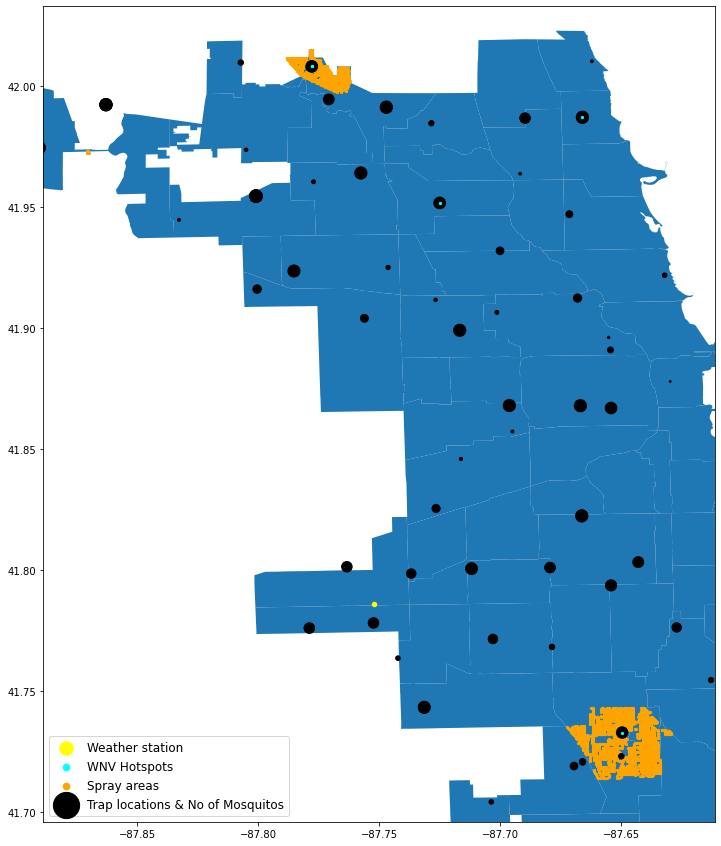

Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER 2013-07-17 00:00:00


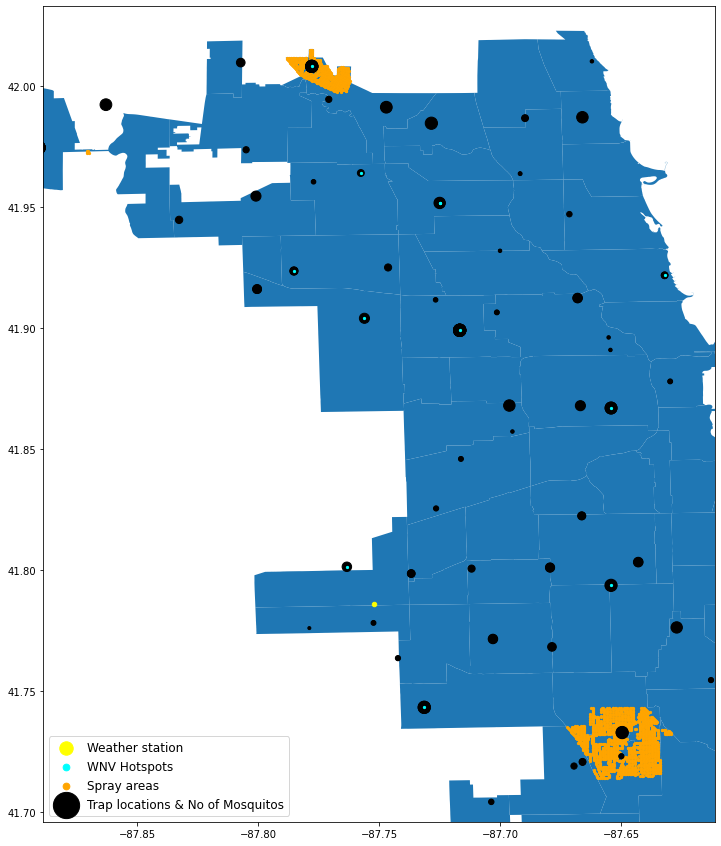

In [16]:
n=1
spray_date = pd.Timestamp(limit_table['Date'][n])

# mosquito numbers and location of hotspots two weeks before spray
two_wks_before = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                                (df_wnvpresent["Date"] < spray_date)],
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                  'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                 }
   
print(f"Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers and location of hotspots two weeks after spray
two_wks_after = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date) &\
                                (df_wnvpresent["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                 'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))] 
                }

print(f"Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 25 July 2013

Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE 2013-07-25 00:00:00


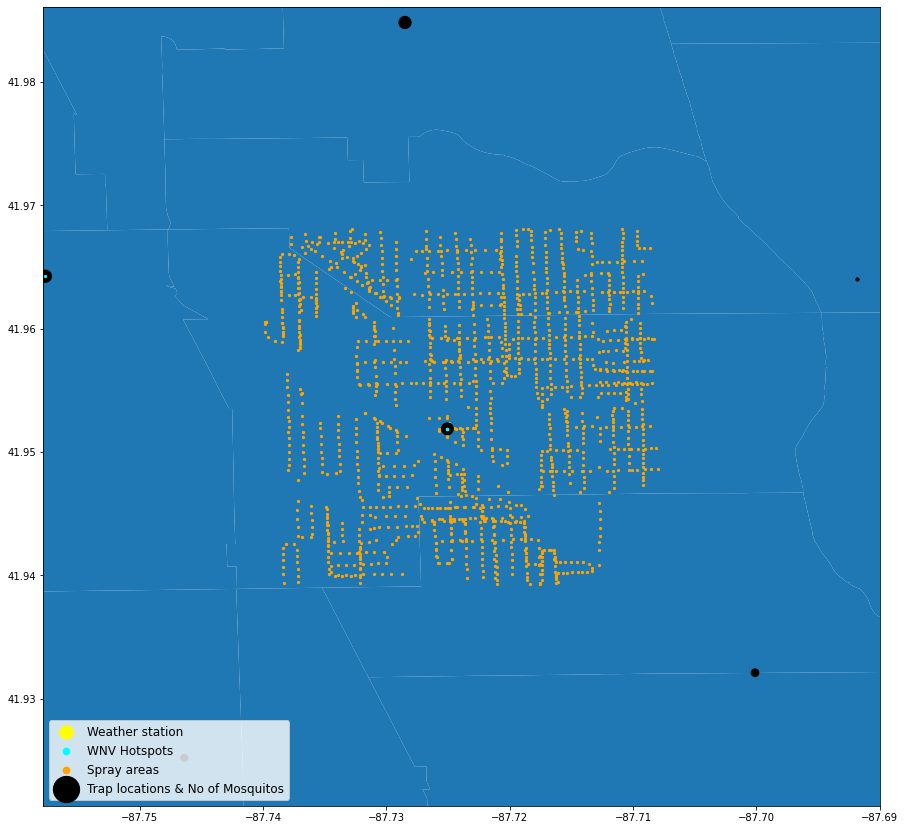

Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER 2013-07-25 00:00:00


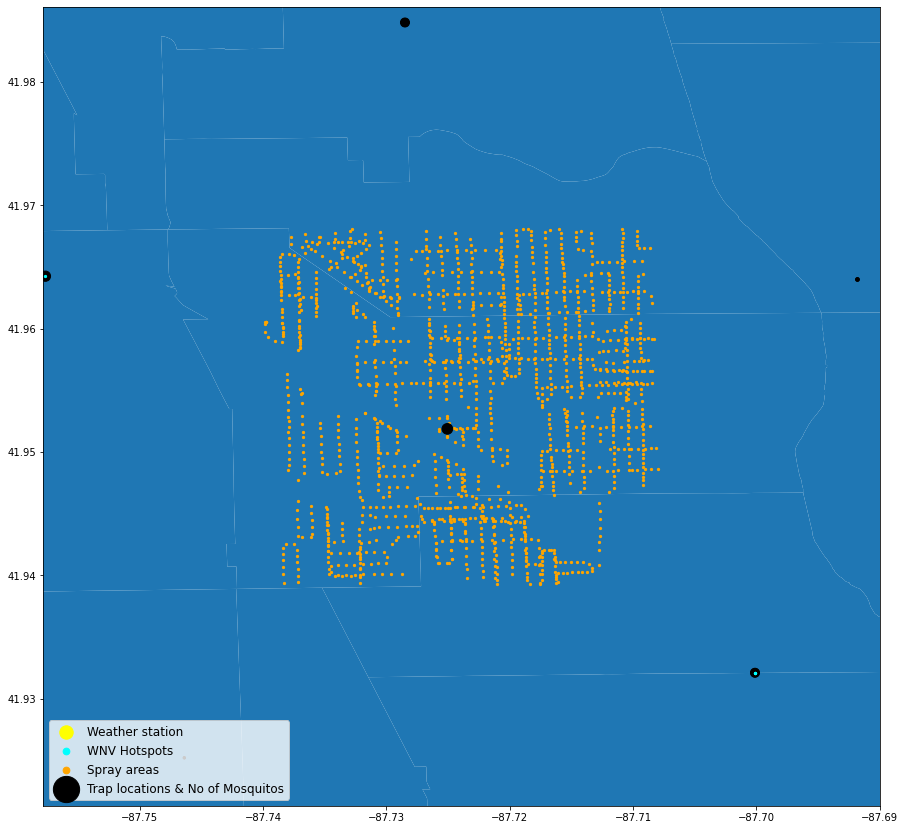

In [17]:
n=2
spray_date = pd.Timestamp(limit_table['Date'][n])

# mosquito numbers and location of hotspots two weeks before spray
two_wks_before = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                                (df_wnvpresent["Date"] < spray_date)],
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                  'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                 }
   
print(f"Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers and location of hotspots two weeks after spray
two_wks_after = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date) &\
                                (df_wnvpresent["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                 'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))] 
                }

print(f"Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 8 August 2013

Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE 2013-07-17 00:00:00


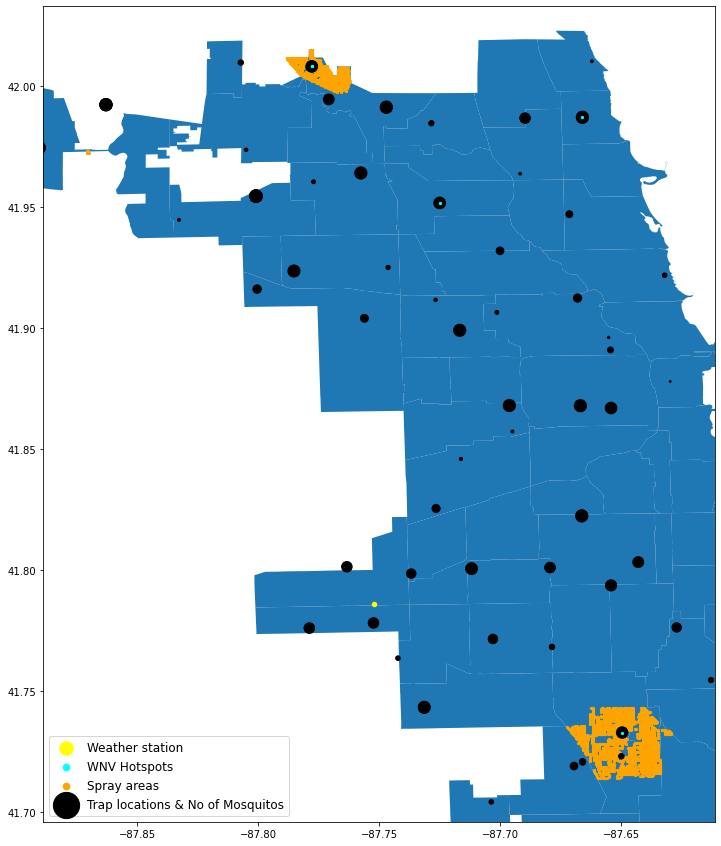

Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER 2013-07-17 00:00:00


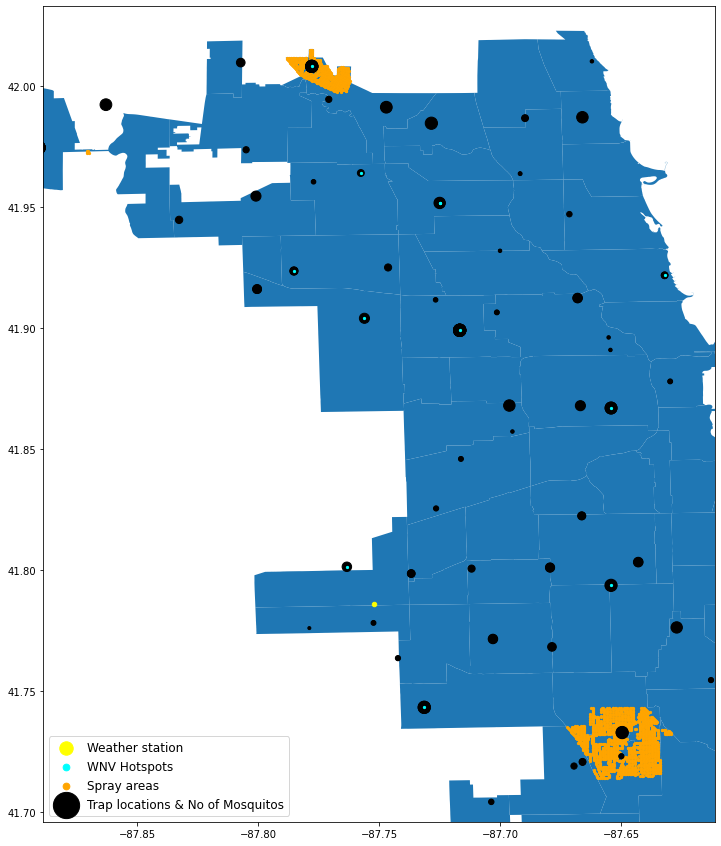

In [18]:
n=3
spray_date = pd.Timestamp(limit_table['Date'][n])

n=1
spray_date = pd.Timestamp(limit_table['Date'][n])

# mosquito numbers and location of hotspots two weeks before spray
two_wks_before = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                                (df_wnvpresent["Date"] < spray_date)],
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                  'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                 }
   
print(f"Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers and location of hotspots two weeks after spray
two_wks_after = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date) &\
                                (df_wnvpresent["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                 'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))] 
                }

print(f"Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 15 August 2013

Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE 2013-08-15 00:00:00


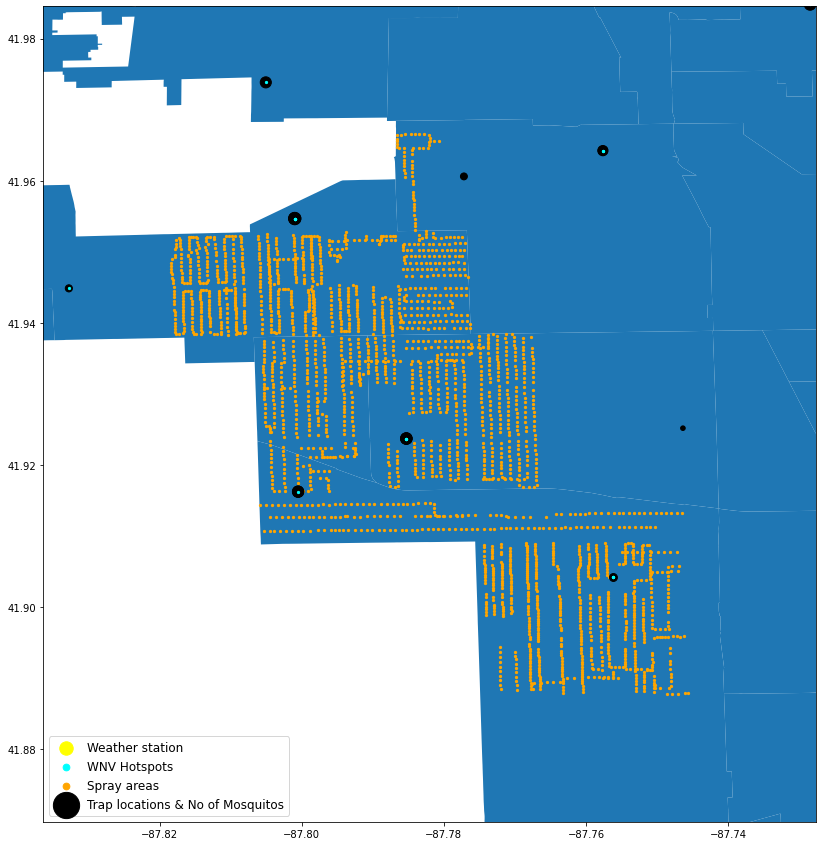

Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER 2013-08-15 00:00:00


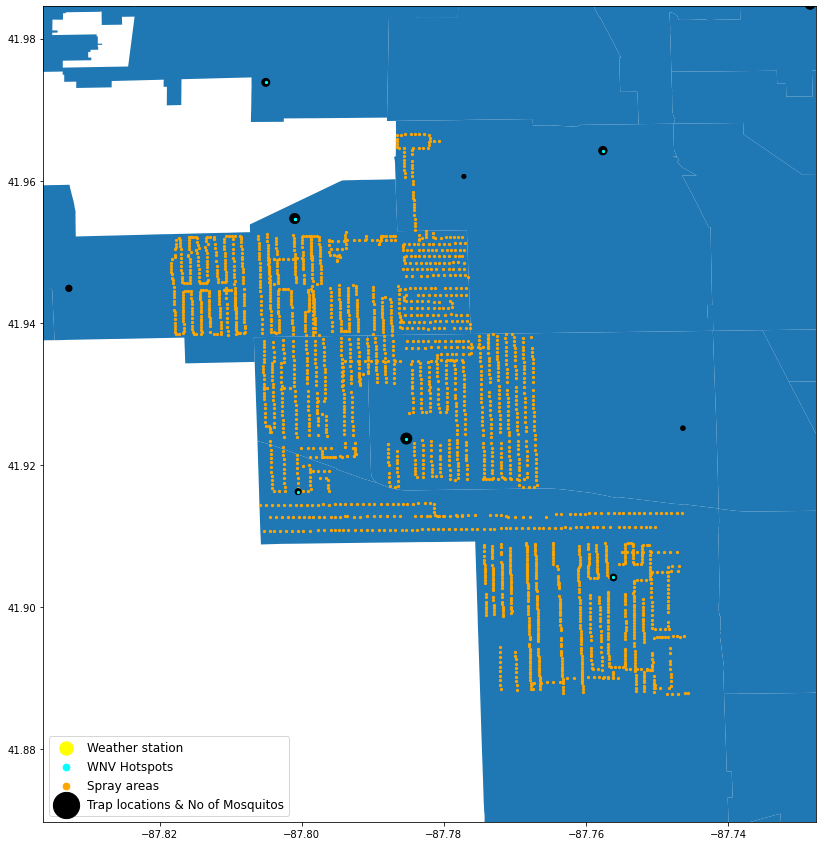

In [19]:
n=4
spray_date = pd.Timestamp(limit_table['Date'][n])

# mosquito numbers and location of hotspots two weeks before spray
two_wks_before = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                                (df_wnvpresent["Date"] < spray_date)],
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                  'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                 }
   
print(f"Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers and location of hotspots two weeks after spray
two_wks_after = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date) &\
                                (df_wnvpresent["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                 'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))] 
                }

print(f"Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 16 August 2013

Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE 2013-08-16 00:00:00


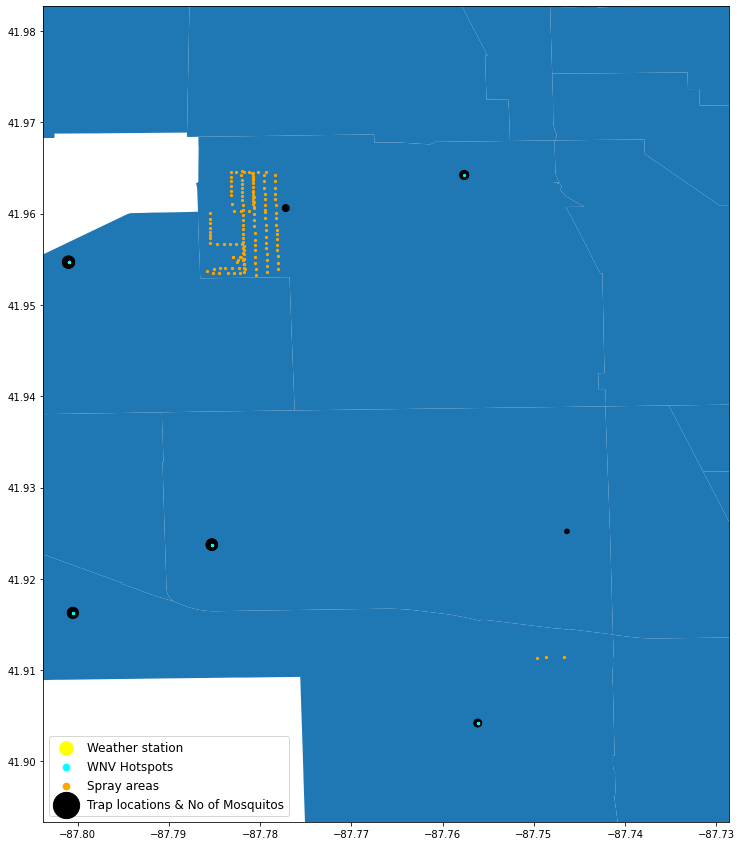

Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER 2013-08-16 00:00:00


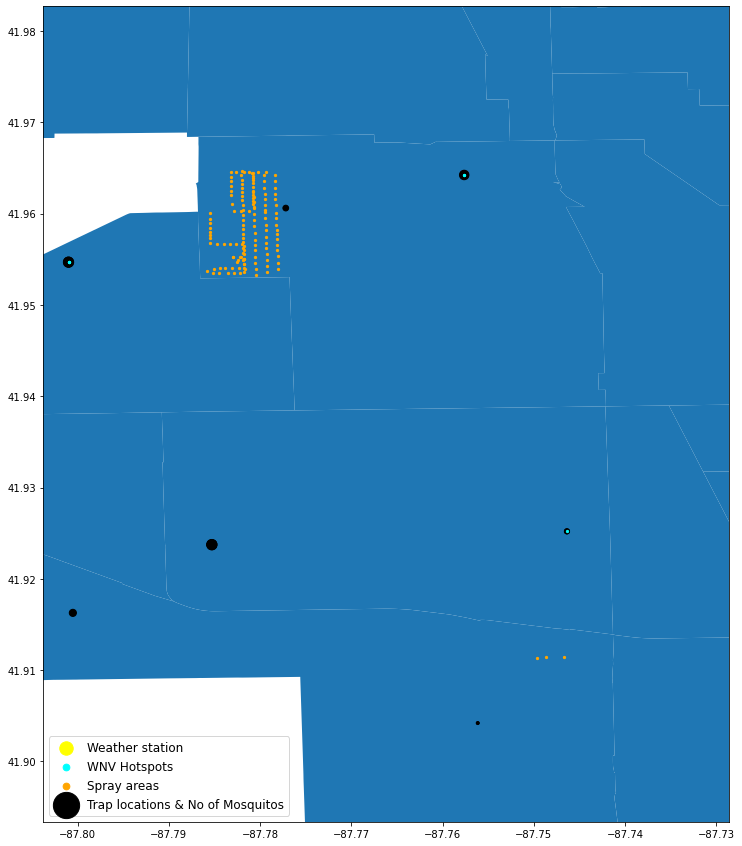

In [20]:
n=5
spray_date = pd.Timestamp(limit_table['Date'][n])

# mosquito numbers and location of hotspots two weeks before spray
two_wks_before = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                                (df_wnvpresent["Date"] < spray_date)],
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                  'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                 }
   
print(f"Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers and location of hotspots two weeks after spray
two_wks_after = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date) &\
                                (df_wnvpresent["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                 'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))] 
                }

print(f"Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 22 August 2013

Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE 2013-08-22 00:00:00


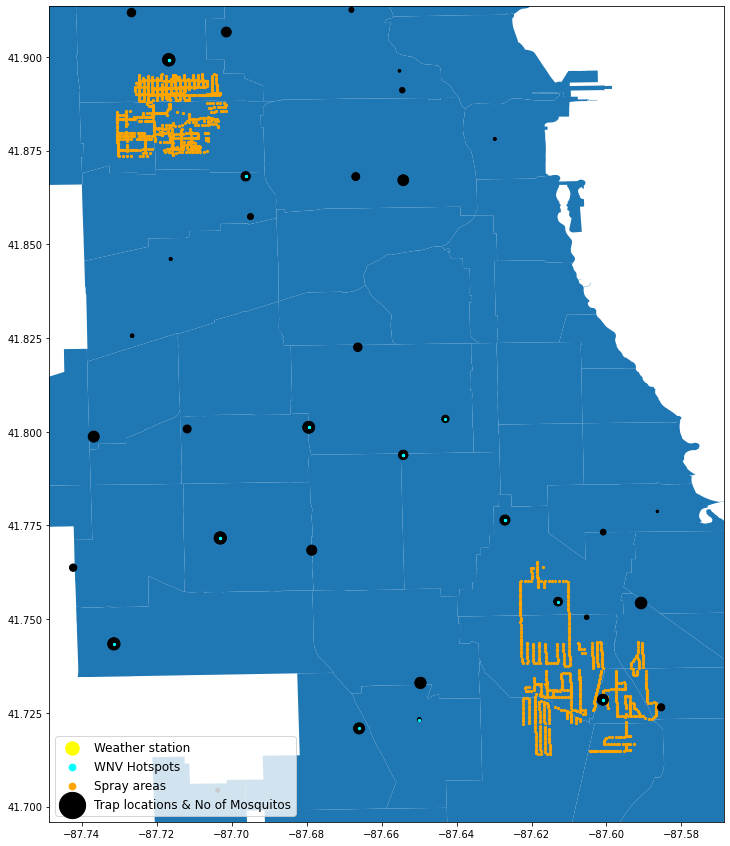

Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER 2013-08-22 00:00:00


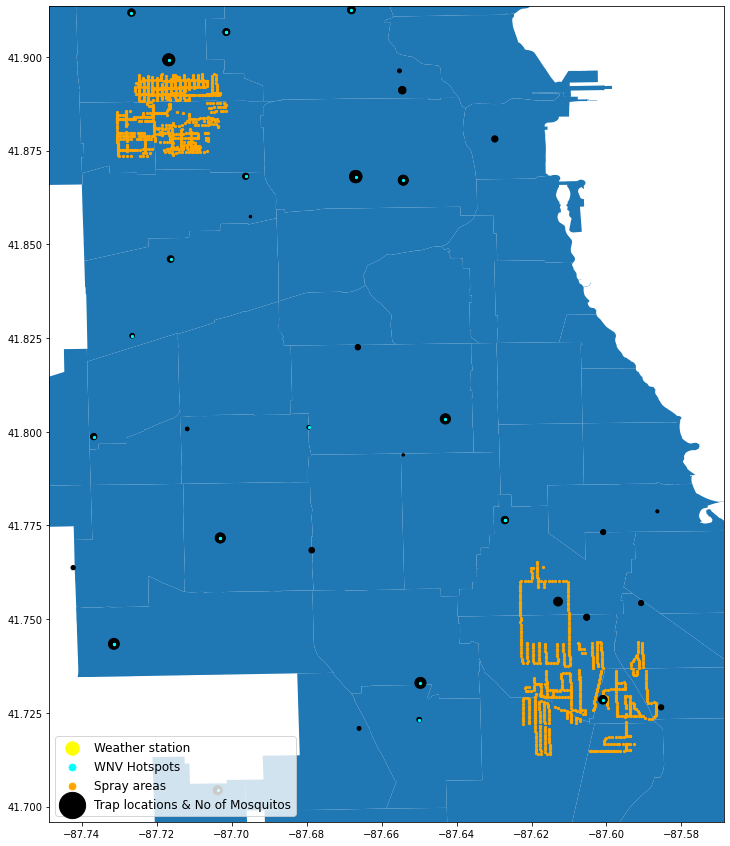

In [21]:
n=6
spray_date = pd.Timestamp(limit_table['Date'][n])

# mosquito numbers and location of hotspots two weeks before spray
two_wks_before = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                                (df_wnvpresent["Date"] < spray_date)],
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                  'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                 }
   
print(f"Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers and location of hotspots two weeks after spray
two_wks_after = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date) &\
                                (df_wnvpresent["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                 'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))] 
                }

print(f"Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 29 August 2013

Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE 2013-08-29 00:00:00


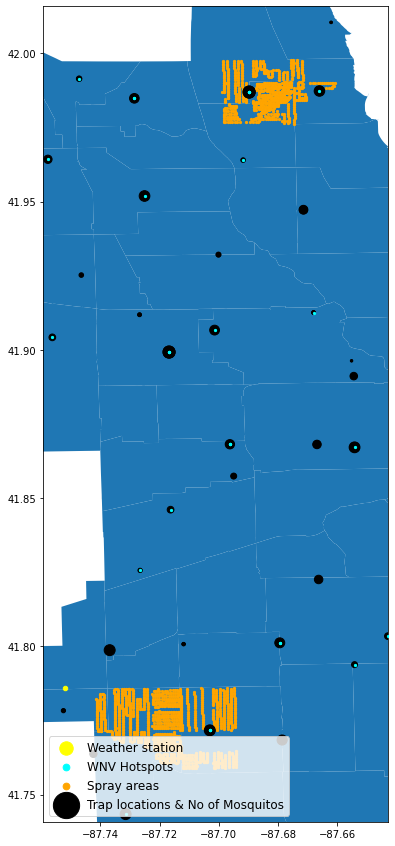

Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER 2013-08-29 00:00:00


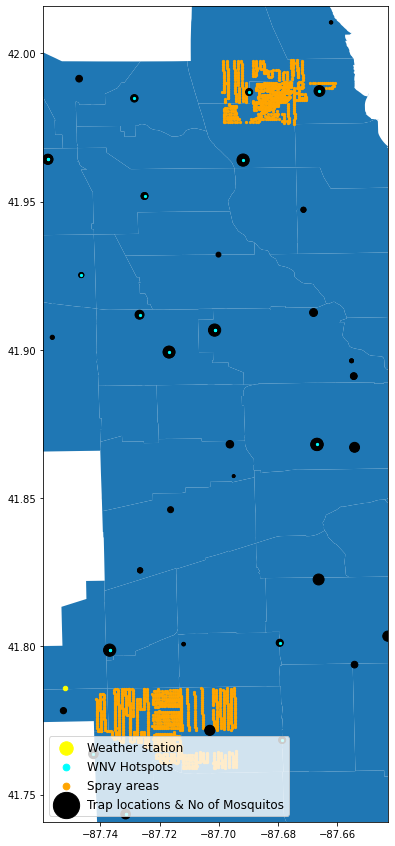

In [22]:
n=7
spray_date = pd.Timestamp(limit_table['Date'][n])

# mosquito numbers and location of hotspots two weeks before spray
two_wks_before = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                                (df_wnvpresent["Date"] < spray_date)],
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                  'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                 }
   
print(f"Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers and location of hotspots two weeks after spray
two_wks_after = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date) &\
                                (df_wnvpresent["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                 'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))] 
                }

print(f"Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Spray effectiveness on 5 September 2013

Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE 2013-09-05 00:00:00


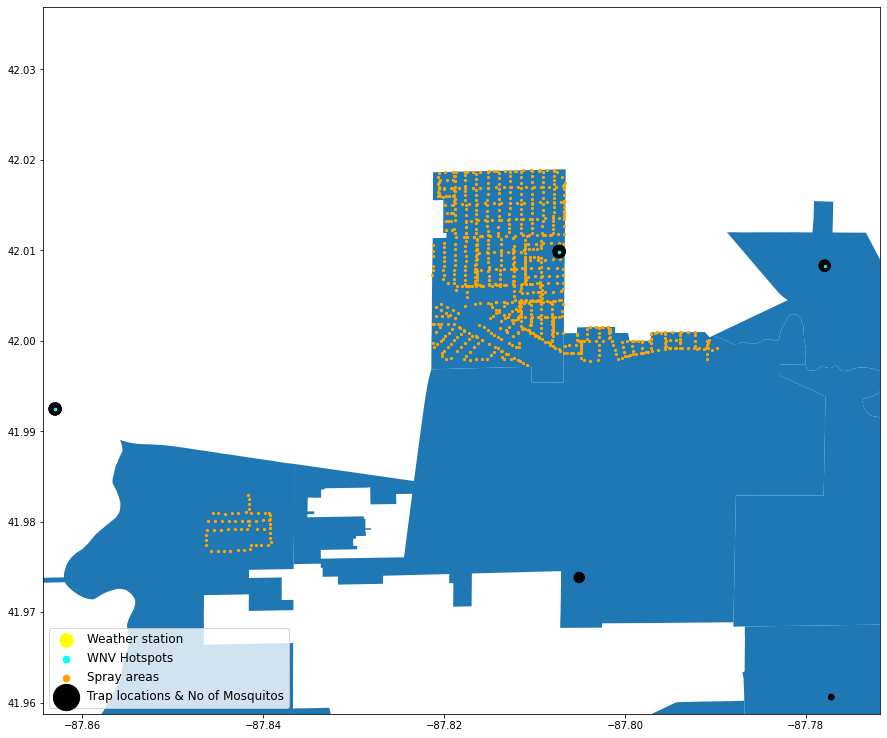

Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER 2013-09-05 00:00:00


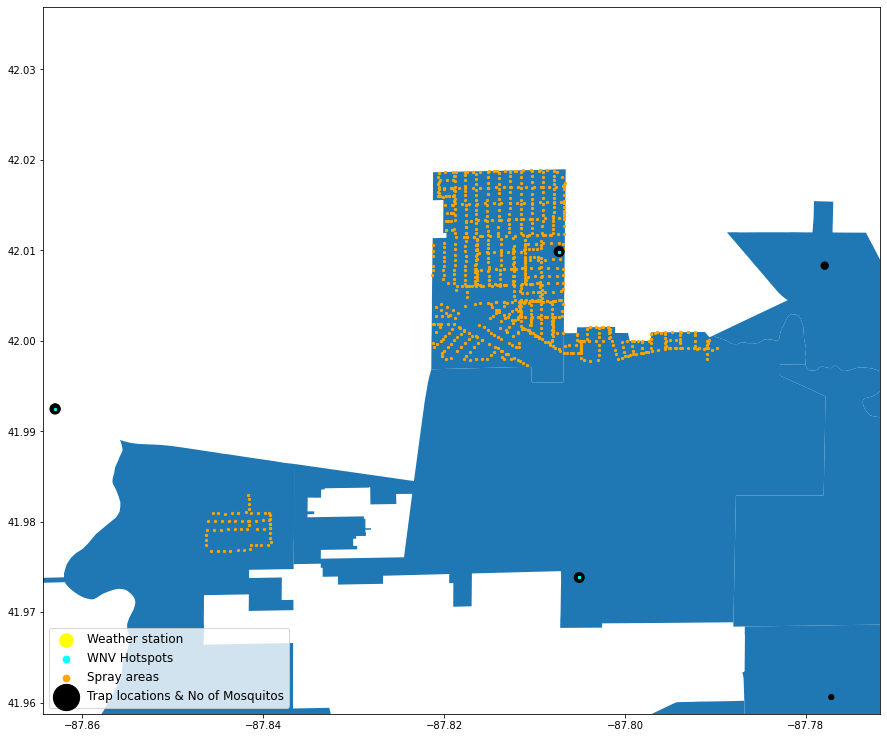

In [23]:
n=8
spray_date = pd.Timestamp(limit_table['Date'][n])

# mosquito numbers and location of hotspots two weeks before spray
two_wks_before = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                                (df_wnvpresent["Date"] < spray_date)],
                  'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                  'Trap locations & No of Mosquitos':\
                  df_train[(df_train["Date"] >= spray_date - datetime.timedelta(weeks=2)) &\
                           (df_train["Date"] < spray_date)], 
                 }
   
print(f"Number of mosquitoes and location of WNV hotspots 2 weeks BEFORE {spray_date}")            
plot_spray(two_wks_before, spray_date)

# mosquito numbers and location of hotspots two weeks after spray
two_wks_after = {'WNV Hotspots':\
                  df_wnvpresent[(df_wnvpresent["Date"] >= spray_date) &\
                                (df_wnvpresent["Date"] < spray_date + datetime.timedelta(weeks=2))],
                 'Spray areas': df_spray[(df_spray["Date"] == spray_date)],
                 'Trap locations & No of Mosquitos':\
                 df_train[(df_train["Date"] >= spray_date) &\
                          (df_train["Date"] < spray_date + datetime.timedelta(weeks=2))] 
                }

print(f"Effect on number of mosquitos and location of WNV hotspots 2 weeks AFTER {spray_date}")
plot_spray(two_wks_after, spray_date)

## Findings from Spray Data

*Back to [Contents](#Contents:)*

#### 1) Spraying done in an ad-hoc manner 
Data from 2011 and 2013 seems to suggest that it was done without prior research 
For e.g. in 16 Aug and 22 Aug 2013, spraying was not done on WNV hotspot areas or areas where trap locations are found

#### 2) Spray not effective with time 
Number of mosquitoes did not drop within spraying area. 
Effectiveness of spraying seemed to reduce later on in the months, perhaps due to mosquitoes developing resistance to pesticides over time

#### 3) Spraying not effective in curbing virus 
WNV hotspots still remain 2 weeks after spraying
Assuming adulticide sprays are applied, which only kills adult mosquitoes, it is not truly effective in reducing virus as mosquito larvae is still alive

## Conclusion
*Back to [Contents](#Contents:)*

WNV is more prevalent under certain conditions, such as longer daylight hours and higher average temperatures.

Spraying efforts should be focused during June to early July; current spraying efforts are ineffective.
Suggest to spray in early June to July, considering the gestation period of mosquitoes resulting in peak WNV cases in August

There may be health issues related to spray chemicals, as pregnant women and children have a greater risk of getting sick from pesticides.

Lastly, we should consider alternatives to spraying, such as larviciding catch basins, which involves dropping tablets in storm drains along the public way that slowly dissolve over a five-month period to prevent mosquito larvae from hatching, and eliminating standing water by ensuring that swimming pools and construction sites are regularly maintained.